In [1]:
# 必要なモジュールをインポートする
import sys
sys.path.append('scripts/')
from robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
# 誤差楕円
def sigma_ellipse(p, cov, n): 
    #共分散行列から固有値と固有ベクトルを算出
    eig_vals, eig_vec = np.linalg.eig(cov)
    #誤差楕円の傾き
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    #楕円のオブジェクトを返す
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [3]:
# カルマンフィルタ
class KalmanFilter:
    # envmap=地図、init_pose=初期姿勢、motion_nose_stds=雑音
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        # 多変量ガウス分布に初期値を与える(信念)
        self.belief = multivariate_normal(mean=init_pose, \
                                        cov=np.diag([1e-10, 1e-10, 1e-10])) 
        # 雑音
        self.motion_noise_stds = motion_noise_stds
        # 受け取った地図をself.map に保持
        self.map = envmap
        #  雑音の割合(0.14)
        self.distance_dev_rate = distance_dev_rate
        # 雑音の標準偏差（0.5）
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):  #観測の更新
        for d in observation:
            z = d[0]
            obs_id = d[1]
            
            ###Hの計算###
            # h(x)は誤差楕円に属するロボットとランドマークの相対姿勢
            # Hはh（x）を線形化するために近似する行列
            mx, my = self.map.landmarks[obs_id].pos
            mux, muy, mut = self.belief.mean
            # ランドマークの座標と平均μの距離を計算
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])
            
            ###Qの計算###
            # カルマンゲインに必要な雑音の計算
            
            # 誤差楕円の中心とランドマークの距離と方角を取得
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)
            # 取得した距離から雑音の標準偏差を算出
            distance_dev = self.distance_dev_rate*hmu[0]
            # Qの算出
            # 距離と方角の標準偏差が独立なため対角行列になる(共分散行列)
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))
            
            ###カルマンゲインの計算###
            # ランドマークを観測した後に、観測結果を誤差楕円に反映させるための行列
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###信念の更新###
            self.belief.mean += K.dot(z - hmu)
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
        
    def motion_update(self, nu, omega, time): #動きの更新
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
        if abs(nu) < 1e-5:         nu = 1e-5
        
        v = self.motion_noise_stds
        # 雑音に関するガウス分布の共分散行列を計算
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        
        # 現在の姿勢の角度θをｔに代入
        t = self.belief.mean[2]
        # ｔ(現在の姿勢の角度θ)からsin,cosを算出
        st, ct = math.sin(t), math.cos(t)
        # ｔ(現在の姿勢の角度θ)と角速度ωでの微小時間後におけるsin,cosの算出
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)
        # 遷移後の姿勢を得るための行列
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        
        # Fの計算
        # 3×3の単位行列
        F = np.diag([1.0, 1.0, 1.0])
        # 非線形モデルを線形化するためにxで偏微分する
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
        
        # self.beliefの更新
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        
    def draw(self, ax, elems):
        
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
# カルマンフィルタのエージェントを作成
class KfAgent(Agent): 
    # time_interval = 周期[s]、nu=並行速度[m/s]、omega=角速度[rad/s]、init_pose=初期位置(x,y)、envmap=地図情報
    # motion_nose_stds=雑音の標準偏差ら('nn'=直進時の直進方向のばらつき、'no'=直進時の回転方向のばらつき、'on'=回転時の直進方向のばらつき、'oo'=回転時の回転方向のばらつき)
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        # Agentのinitを継承
        super().__init__(nu, omega)
        # カルマンフィルタのクラスのインスタンス化
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds)
        # 周期[s]
        self.time_interval = time_interval
        
        # 初期数
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):  ###kfagent2
        # 移動後の更新
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        # 現在の並進速度と角速度
        self.prev_nu, self.prev_omega = self.nu, self.omega
        # 観測後の更新
        self.kf.observation_update(observation)   #追加
        # 現在の速度と角速度を返す
        return self.nu, self.omega
        
    # 描画
    def draw(self, ax, elems): #追加
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


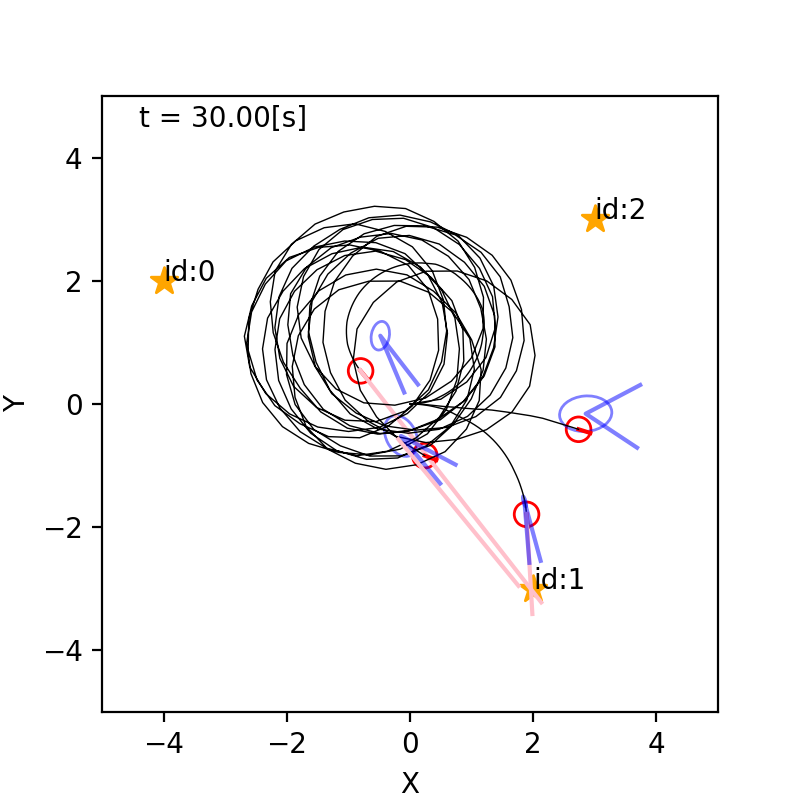

In [5]:
if __name__ == '__main__': 
    # 0.1秒周期
    time_interval = 0.1
    # 30秒動作させる
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()          
    # (-4,2)にランドマークを追加
    m.append_landmark(Landmark(-4,2))
    # (2,-3)にランドマークを追加
    m.append_landmark(Landmark(2,-3))
    # (3,3)にランドマークを追加
    m.append_landmark(Landmark(3,3))
    # ワールドに反映
    world.append(m)          

    ### ロボットを作る ###
    # (0,0,0) に左回転、直進=0.2 [m/s]、角速度=π/18 [rad] のロボットを定義
    circling = KfAgent(time_interval, 0.2, 10/180*math.pi, np.array([0, 0, 0]).T, m)
    # ロボットの変数を定義
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    # ワールドに追加
    world.append(r)
    # (0,0,0) に直進、直進=0.1 [m/s]、角速度=0 [rad] のロボットを定義
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)
    # ロボットの変数を定義
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")
    # ワールドに追加
    world.append(r)
    # (0,0,0) に回右回転、直進=0.1 [m/s]、角速度= -π/60 [rad] のロボットを定義
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)
    # ロボットの変数を定義
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")
    # ワールドに追加
    world.append(r)
    
    ### 追加　###
    circling = KfAgent(time_interval, 5, 180/180*math.pi, np.array([0, 0, 0]).T, m)
    # ロボットの変数を定義
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    # ワールドに追加
    world.append(r)
    ##########

    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき

In [6]:
# 　ランドマークが観測されない場合、速度が早いと誤差楕円も大きくなる